## Import necessary libraries

In [1]:
import numpy as np
from PIL import Image
import torch
from scipy.stats import multivariate_normal
from IPython.display import display
import matplotlib.pyplot as plt

# Task 1: Simple Image Operations

### 1. Load image

In [78]:
img = Image.open('Capybara.jpg')
array = np.asarray(img)

### 2. Print width, height, and number of channels and plot the image

Height: 600, Width: 800, Channels: 3


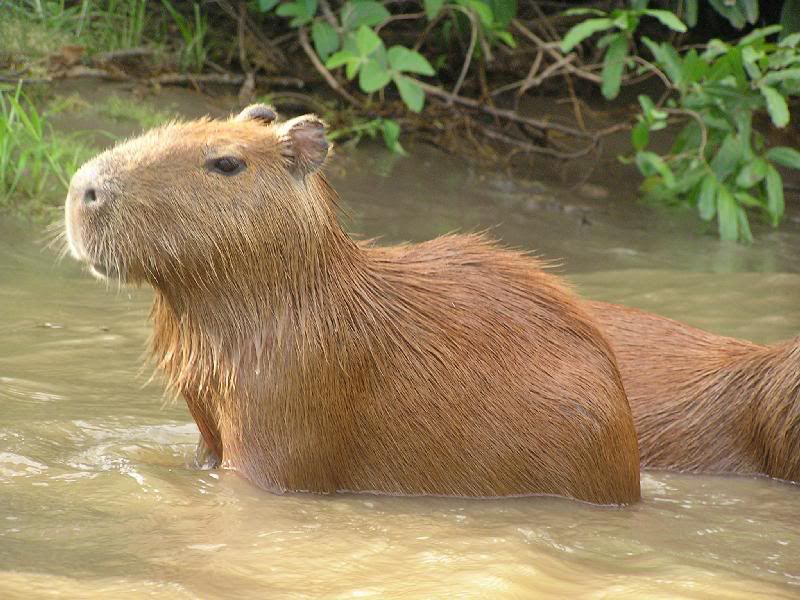

In [79]:
# Print h, w, c
height = array.shape[0]
width = array.shape[1]
channels = array.shape[2]
print(f'Height: {height}, Width: {width}, Channels: {channels}')

# Display the image
display(img)

### 3. Crop a random patch of size 256x256 from the image

Random patch:


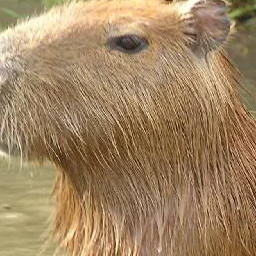

In [85]:
# Determine the patch coordinates
patch_height = 256
patch_width = 256
h = np.random.randint(0, height - patch_height)
w = np.random.randint(0, width - patch_width)

# Crop the patch and display
patch_array = array[h:h + patch_height, w:w + patch_width]
patch = Image.fromarray(patch_array)

print('Random patch:')
display(patch)

### 4. Convert the image patch to grayscale

Grayscale patch:


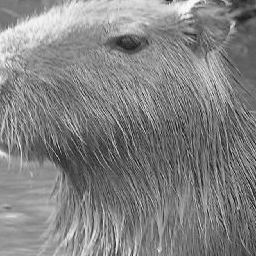

In [86]:
patch_array = np.mean(patch_array, axis=2)
gray_patch_img = Image.fromarray(patch_array.astype(np.uint8))

print('Grayscale patch:')
display(gray_patch_img)

### 5. Insert the grayscale patch back into the original image

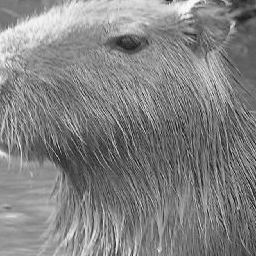

In [87]:
display(Image.fromarray(patch_array.astype(np.uint8)))

Original image with the inserted grayscale patch:


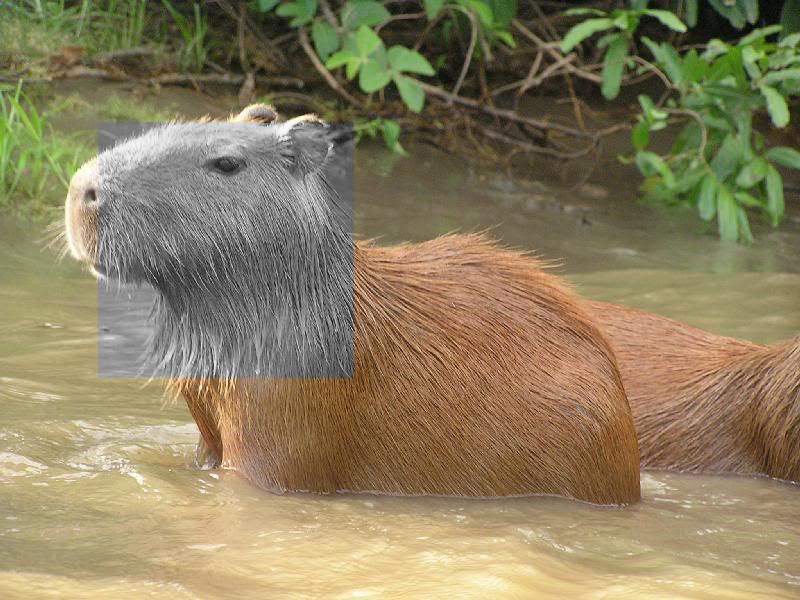

In [88]:
new_array = np.copy(array)
# replace the original patch with the gray scale one
# patch array has only one channel. You can either do this or do it e.g. with a for-loop
new_array[h:h + patch_height, w:w + patch_width] = np.repeat(patch_array[:, :, np.newaxis], 3, axis=2)
new_img = Image.fromarray(new_array)

print('Original image with the inserted grayscale patch:')
display(new_img)

### 6. Resize the image with the inserted gray patch 

Resized image with the inserted grayscale patch:


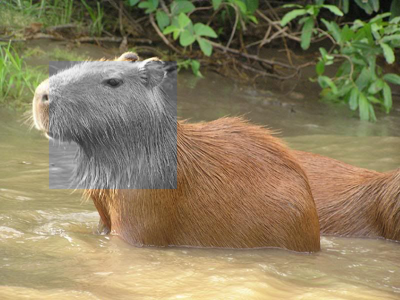

In [89]:
resized_img = new_img.resize((width // 2, height // 2))

print('Resized image with the inserted grayscale patch:')
display(resized_img)

# Task 2: Convolution and Filters

### Utils
take care of the range of the value before plot the images

In [5]:
def display_img(x, norm=False):
    """
    Displays image
    """
    x = np.copy(x)
    # Normalize if necessary
    if norm:
        x = (x - np.min(x)) / (np.max(x) - np.min(x))
    # Scale and convert to uint8 format for PIL plotting
    x *= 255
    x = x.astype(np.uint8)
    # Handle channel dimension
    if len(x.shape) == 2:
        x = x[:, :, np.newaxis]
    if x.shape[2] == 1:
        x = np.repeat(x, 3, axis=2)

    display(Image.fromarray(x))

def load_img(path, grayscale=False):
    """
    Loads image from given path, converts to float and normalize to [0,1] interval
    """
    img = Image.open(path)
    a = np.asarray(img, dtype=np.float32) / 255
    # Convert to grayscale if necessary
    if grayscale:
        a = np.mean(a, axis=2, keepdims=True)
    return a

### 1. Implement convolution operation

In [91]:
def conv2d(x, kernel):
    """
    Performs a 2D convolution operation with a single kernel.

    Args:
        x      (array): the input array of shape (H, W, 1).
        kernel (array): the kernel that is convolved over the input.

    Returns:
        out    (array): the output array.
    """
    assert kernel.shape[0] == kernel.shape[1]

    x_height = x.shape[0]
    x_width = x.shape[1]
   
    f_size = kernel.shape[0]
    out_height = int(x_height - f_size + 1)
    out_width = int(x_width - f_size + 1)
    out = np.zeros((out_height, out_width, 1))

    w = 0
    h = 0
    for h in range(out_height):
        for w in range(out_width):
            out[h, w] = np.sum(x[h:h + f_size, w:w + f_size] * kernel)

    return out

### 2. Implement a Gaussian filter
#### mistake-1 wrong bracket

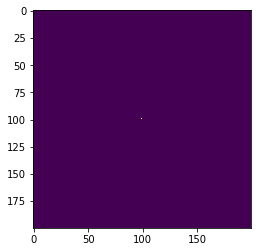

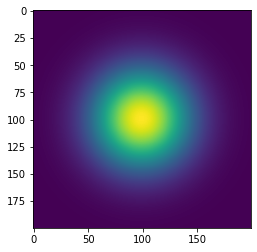

In [97]:
def gaussian_filter_wrong(size: int, var: float) -> np.ndarray:
    
    # if size is not odd number, the resulting kernel shifts the image
    grid_range = np.linspace(-np.floor((size-1)/2), np.ceil((size-1)/2), size)
    x, y = np.meshgrid(grid_range, grid_range)
    kernel = (1/2*np.pi*var) * np.exp(-(1/2*var)*(np.square(x)+np.square(y)))
    
    # normalize the filter
    return kernel / np.sum(kernel)

def gaussian_filter_correct(size: int, var: float) -> np.ndarray:
    
    # if size is not odd number, the resulting kernel shifts the image
    grid_range = np.linspace(-np.floor((size-1)/2), np.ceil((size-1)/2), size)
    x, y = np.meshgrid(grid_range, grid_range)
    kernel = 1./(2*np.pi*var) * np.exp(-1./(2*var)*(np.square(x)+np.square(y)))
    
    # normalize the filter
    return kernel / np.sum(kernel)


kernel = gaussian_filter_wrong(200, var=1000)
plt.imshow(kernel)
plt.show()
kernel = gaussian_filter_correct(200, var=1000)
plt.imshow(kernel)
plt.show()

####  a 2-D gaussian is just a product of 2 1-D along each axis, see line of `np.dot(b.T, b)`

In [92]:
def gaussian_filter(size, mean=0, var=1):
    """
    Returns an isotropic Gaussian filter with.
    
    Args:
        size       (int): the size of the kernel.
        mean (float/int): the mean of the Gaussian.
        var  (float/int): the variance of the Gaussian.

    Returns:
        f        (array): the Gaussian filter of shape (size, size, 1).
    """
    half = size // 2
    a = np.arange(-half, size - half)
    b = multivariate_normal.pdf(a, mean=mean, cov=var)
    b = b.reshape(1, -1)
    f = np.dot(b.T, b)
    f /= np.sum(f)
    return f[:, :, np.newaxis]

Gaussian filter:


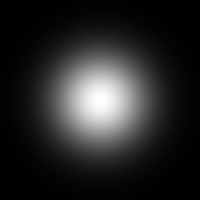

Gaussian filter with small var:


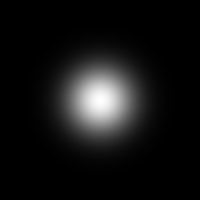

Gaussian filter with mean value:


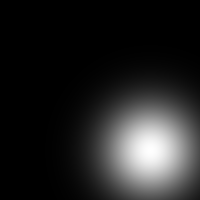

In [93]:
f = gaussian_filter(size=200, mean=0, var=1000)
f_var = gaussian_filter(size=200, mean=0, var=500)
f_shift = gaussian_filter(size=200, mean=50, var=1000)

print('Gaussian filter:')
display_img(f, norm=True)

print('Gaussian filter with small var:')
display_img(f_var, norm=True)

print('Gaussian filter with mean value:')
display_img(f_shift, norm=True)

### 3. Apply Gaussian filter to image

Original image:


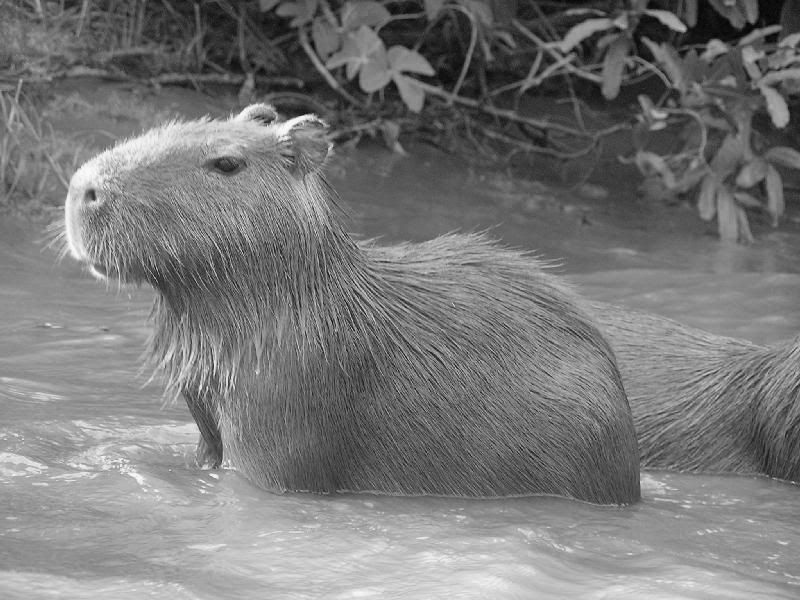

Gaussian filtered image:


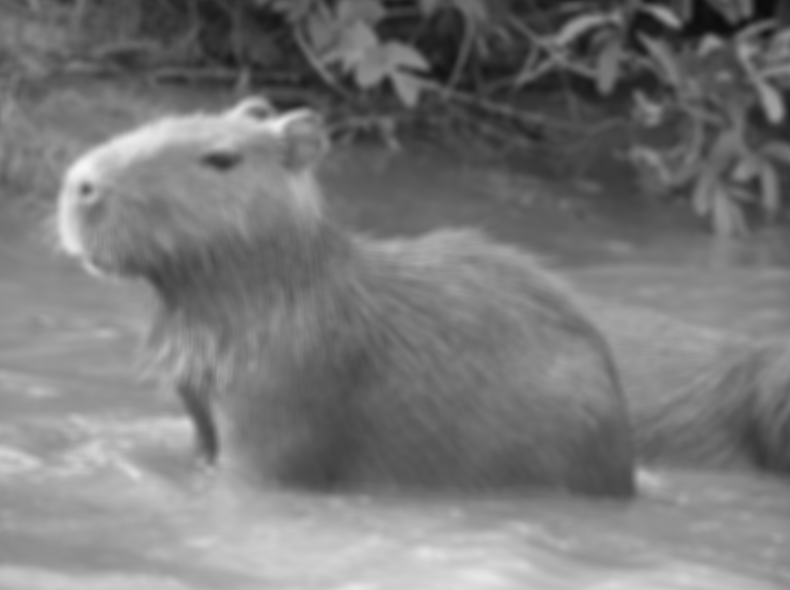

In [94]:
array = load_img(path='Capybara.jpg', grayscale=True)
w = gaussian_filter(size=11, mean=0, var=20)
array_filtered = conv2d(array, kernel=w)

print('Original image:')
display_img(array)
print('Gaussian filtered image:')
display_img(array_filtered)

### 4. Implement and apply Laplacian filter to image

Original image:


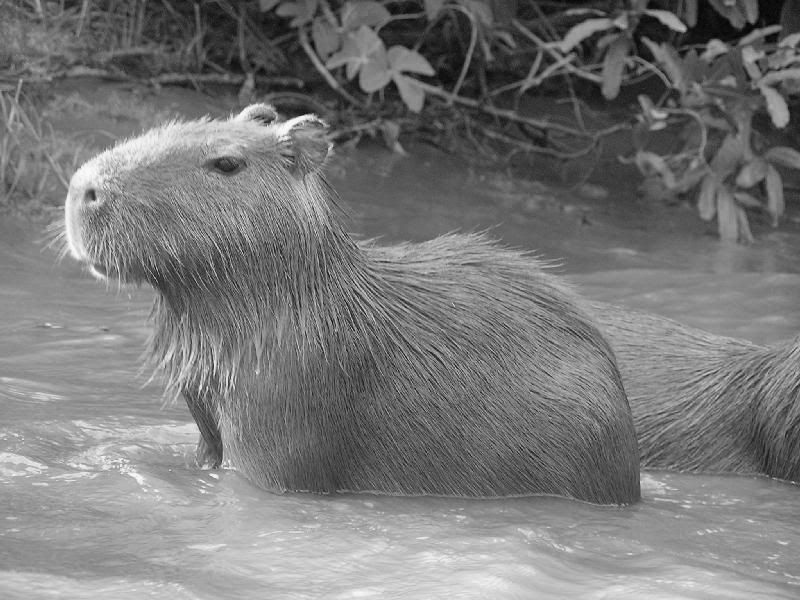

Laplacian filtered image:


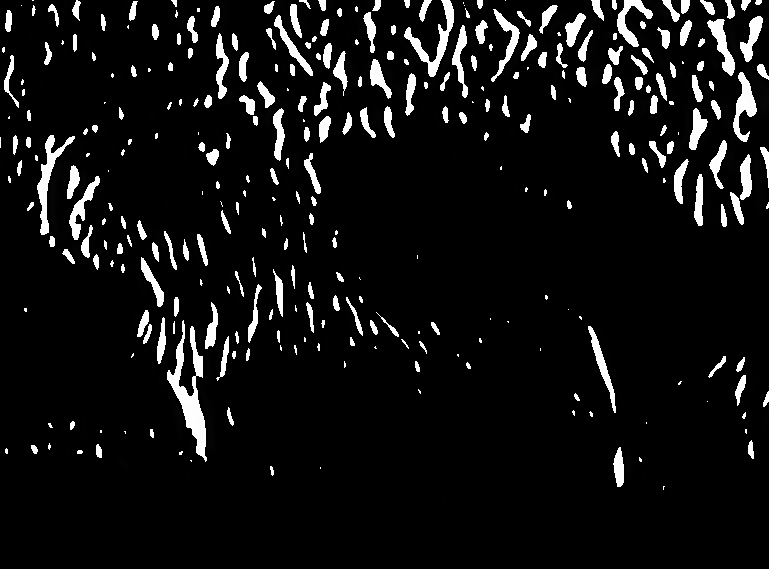

In [69]:
laplacian_filter = np.asarray([[0, -1, 0],[-1, 4, -1],[0, -1, 0]], dtype=np.float32)


array = load_img(path='Capybara.jpg', grayscale=True)
# First gaussian filter to smoothen the image, then laplacian filter
w = gaussian_filter(size=30, mean=0, var=15)
array_filtered = conv2d(array, kernel=w)
array_filtered = conv2d(array_filtered, kernel=laplacian_filter)

print('Original image:')
display_img(array)
print('Laplacian filtered image:')
display_img(array_filtered)

#### If you only apply laplacian and use plt to plot without taking care of the value range, you would probably have a hard time to see sth

Laplacian filtered image with plt:
 you can still see sth but not that much


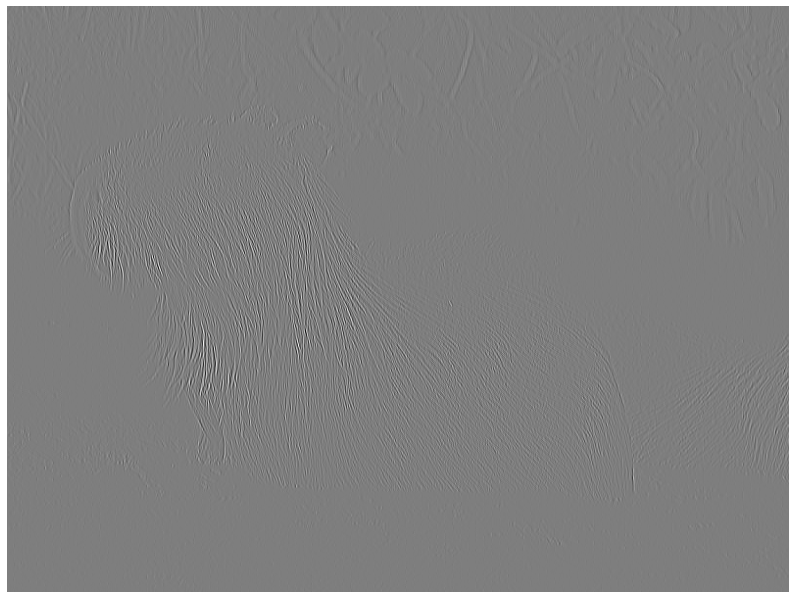

Laplacian filtered image w/ previous helper function:


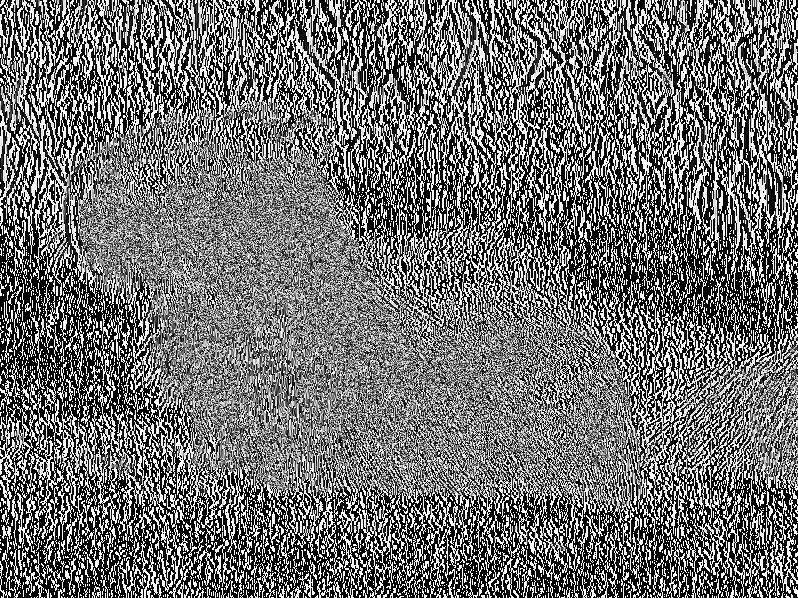

In [125]:

array = load_img(path='Capybara.jpg', grayscale=True)
# First gaussian filter to smoothen the image, then laplacian filter
w = gaussian_filter(size=30, mean=0, var=15)
# array_filtered = conv2d(array, kernel=w)
array_filtered = conv2d(array, kernel=laplacian_filter)


print('Laplacian filtered image with plt:\n you can still see sth but not that much')
# set the figure size larger
plt.figure(figsize=(14,14))
plt.imshow(array_filtered,cmap='gray')
plt.axis('off')
plt.show()
print('Laplacian filtered image w/ previous helper function:')
display_img(array_filtered)

LoG filtered image:


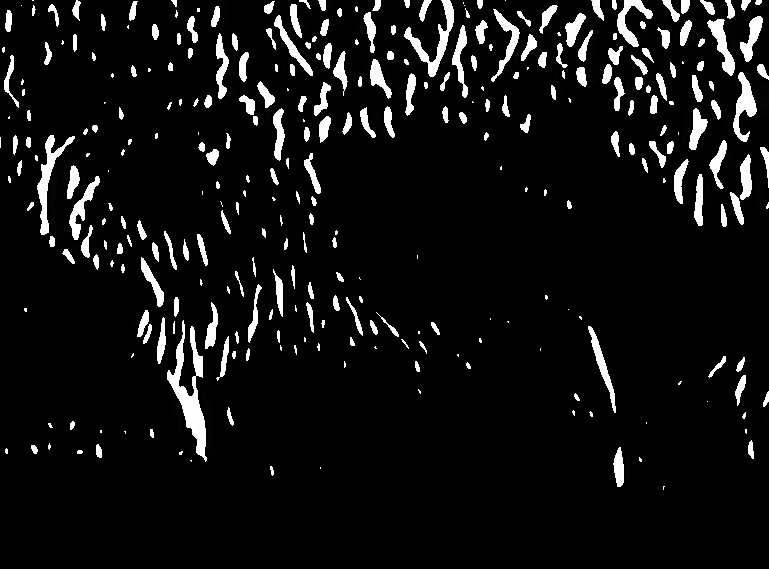

In [70]:
# change the order
array_filtered = conv2d(array, kernel=laplacian_filter)
array_filtered = conv2d(array_filtered, kernel=w)

print('LoG filtered image:')
display_img(array_filtered)

LoG filtered image:


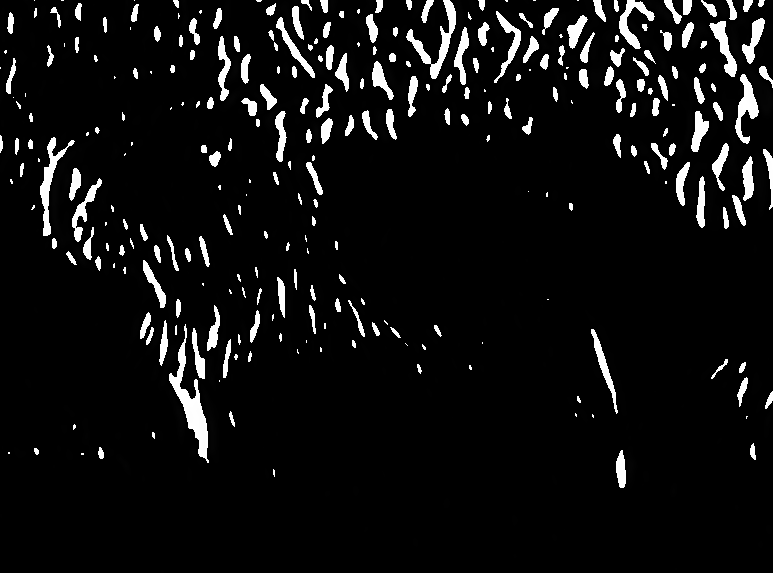

In [47]:
LoG = conv2d(w, kernel=laplacian_filter)
array_LoG = conv2d(array, kernel=LoG)

print('LoG filtered image:')
display_img(array_LoG)

Laplacian filter detects edges by taking the *second derivative* of a given image. Although it is not perfect at detecting edges in our image, its functionality is clearly visible.

### 5. Problems with handcrafted filters

Even though we have some useful filters for image manipulations, it is not feasible and efficient to craft hundreds (let alone thousands) of them for downstream tasks such as classification. Therefore, in the deep learning era, we are learning filters needed to solve these tasks using backpropagation algorithm with proper loss functions.

# Task 3: Introduction to PyTorch

### 1. Convert NumPy array to PyTorch tensor and vice versa

torch.Size([600, 800, 3])
torch.Size([3, 800, 600])
torch.Size([600, 800, 3])
(600, 800, 3)
Original image:


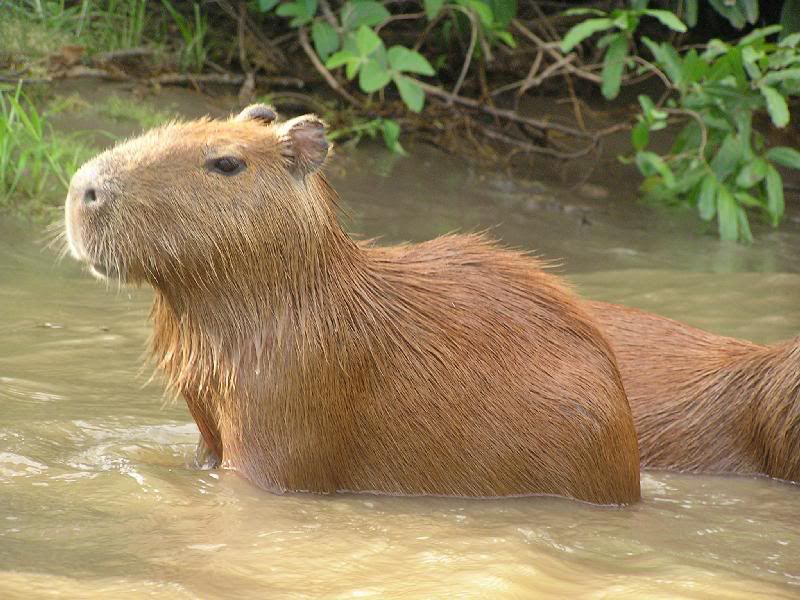

Image after the manipulations should be the same as the original:


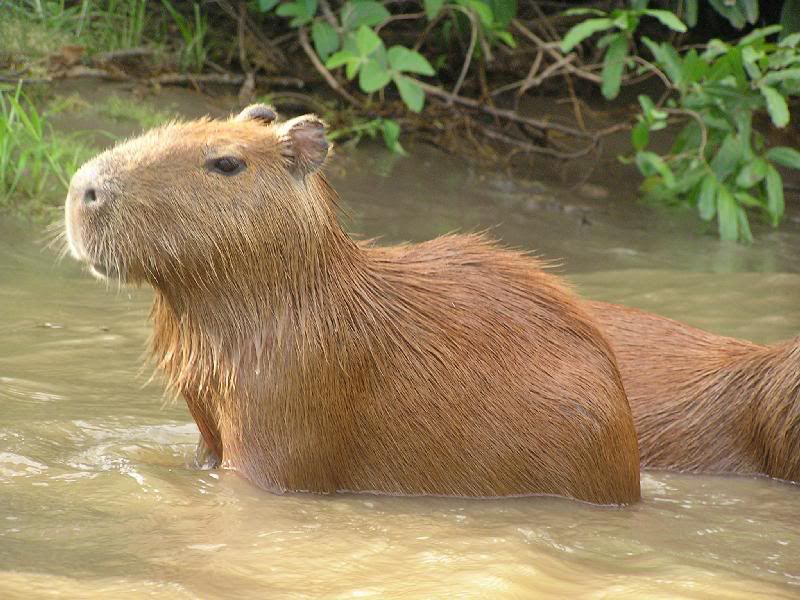

In [71]:
# 1.1
array = load_img(path='Capybara.jpg')

# 1.2
t = torch.from_numpy(array)
print(t.shape)

# 1.3
t = t.permute(2, 1, 0)
print(t.shape)

# 1.4
t = t.permute(2, 1, 0)
print(t.shape)

# 1.5
array_back = t.numpy()
print(array_back.shape)

#1.6
print('Original image:')
display_img(array)
print('Image after the manipulations should be the same as the original:')
display_img(array_back)

### 2. Create a PyTorch convolution operator

In [75]:
# 2.1
x = np.random.rand(5, 5, 1)
w = np.random.rand(2, 2, 1)


# 2.3 & 2.4
xx = torch.from_numpy(x)
xx = torch.unsqueeze(xx, 0)
# or you can do xx = xx[..., None]
xx = xx.permute(0, 3, 1, 2)

ww = torch.from_numpy(w)
ww = torch.unsqueeze(ww, 0)
ww = ww.permute(0, 3, 1, 2)

# 2.2
conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, stride=1, padding=0, bias=False)
conv.weight = torch.nn.Parameter(ww)

# 2.5
y = conv2d(x, kernel=w)
# 2.6
yy = conv(xx)


# 2.7 Check if both convolutions produce the same outputs
print('Output of PyTorch convolution:')
print(yy[0, 0].detach().numpy())
print('\nOutput of our convolution implementation in NumPy:')
print(y[:, :, 0])

Output of PyTorch convolution:
[[0.25777261 0.92737125 1.11007329 1.49616737]
 [0.9070099  1.1207757  0.65871076 0.39624834]
 [0.6342805  0.61343501 1.16255425 0.71145526]
 [1.16587651 0.9898647  0.5161014  0.88298431]]

Output of our convolution implementation in NumPy:
[[0.25777261 0.92737125 1.11007329 1.49616737]
 [0.9070099  1.1207757  0.65871076 0.39624834]
 [0.6342805  0.61343501 1.16255425 0.71145526]
 [1.16587651 0.9898647  0.5161014  0.88298431]]


### 3. Apply Gaussian filter using nn.Conv2d

Original image:


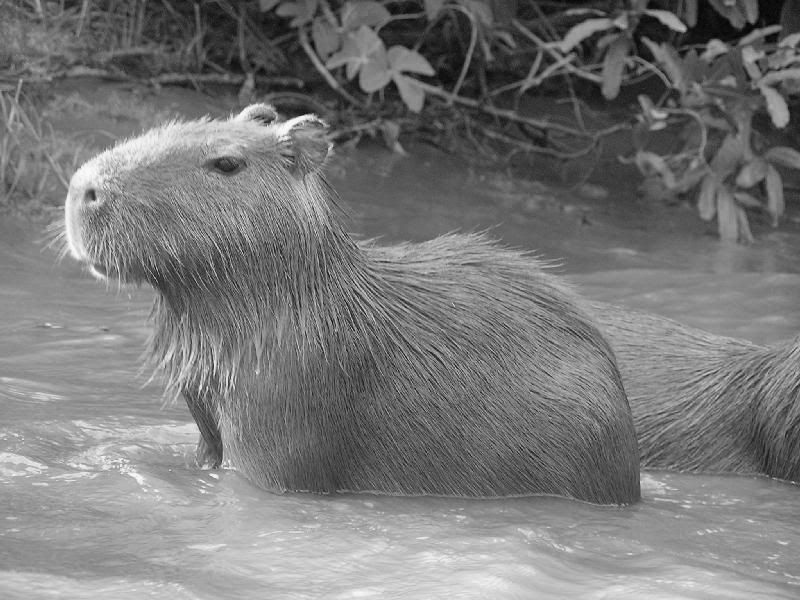

Filtered image:


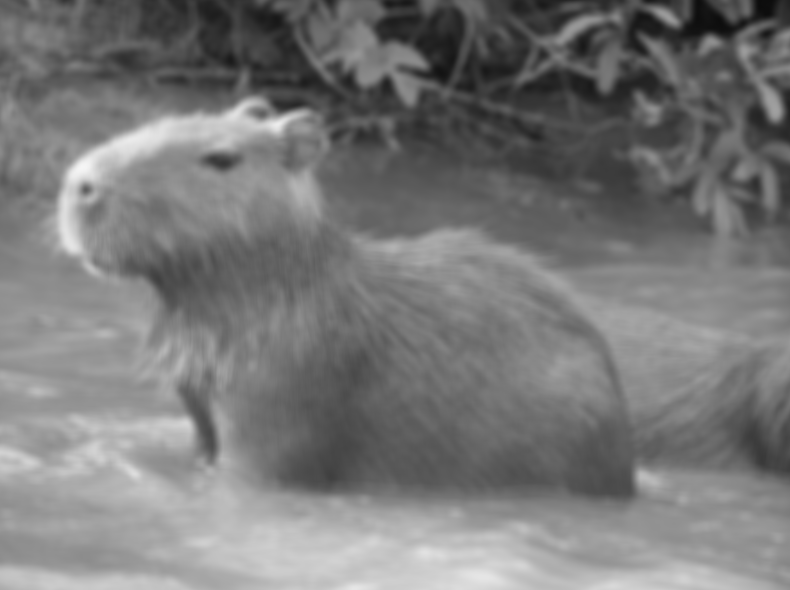

In [76]:
x = load_img(path='Capybara.jpg', grayscale=True)
xx = torch.from_numpy(x)
xx = torch.unsqueeze(xx, 0)
xx = xx.permute(0, 3, 1, 2)

w = gaussian_filter(size=11, mean=0, var=20)
ww = torch.from_numpy(w)
ww = torch.unsqueeze(ww, 0)
ww = ww.permute(0, 3, 1, 2)

conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=10, stride=1, padding=0, bias=False)
conv.weight = torch.nn.Parameter(ww.float())

xx_filtered = conv(xx)
xx_filtered = xx_filtered.permute(0, 2, 3, 1)
xx_filtered = xx_filtered.detach().numpy()[0]

print('Original image:')
display_img(x)
print('Filtered image:')
display_img(xx_filtered)